# Image Generation and Manipulation Overview

A wide range of tools are available for generating and manipulation images programmatically.

Where this is done *in situ*, the local context should help the relationship between text and image to remain consistent.

## Generating Images

## Manipulating Images

### `skimage`

The [`skimage` (scikit-image)](https://scikit-image.org/docs/stable/overview.html) Python package provides a wide range of image processing tools.

In [ ]:
%%capture
try:
    import lcapy
except:
    %pip install lcapy

### Colour separation

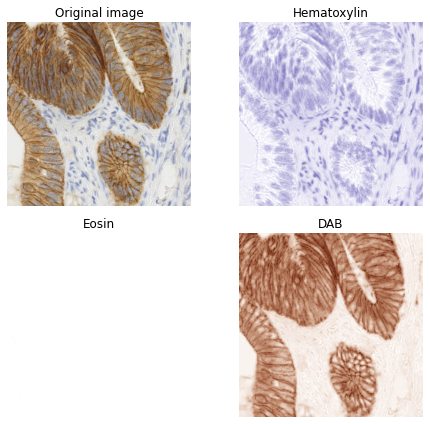

In [5]:
#Example from http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed, hed2rgb

# Example IHC image
ihc_rgb = data.immunohistochemistry()

# Separate the stains from the IHC image
ihc_hed = rgb2hed(ihc_rgb)

# Create an RGB image for each of the stains
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

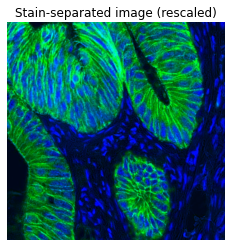

In [6]:
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB channels and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
# respectively
zdh = np.dstack((null, d, h))

fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdh)
axis.set_title('Stain-separated image (rescaled)')
axis.axis('off')
plt.show()

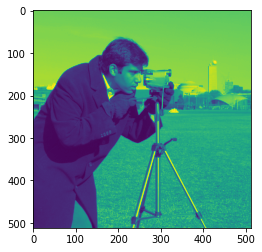

In [8]:
import numpy as np

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt

image = camera()
plt.imshow(image);

In [9]:
#What is the size of the image in x/y pixels?
image.shape

(512, 512)

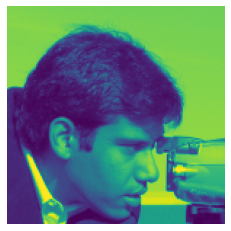

In [10]:
#We can zoom in to a part of the image
cropped_image = image[50:200, 150:300]
plt.axis('off')
plt.imshow(cropped_image);

A wide range of filtering opportunities exist. For example, edge detection:

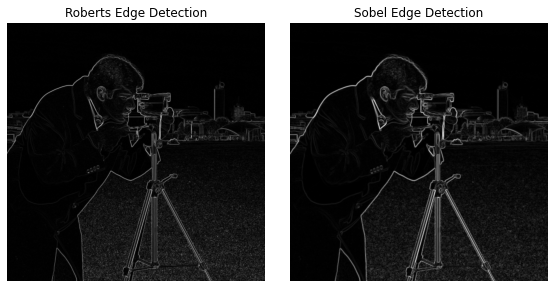

In [11]:
#http://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html

edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

#Other sets of image processing examples to try:
#https://auth0.com/blog/image-processing-in-python-with-pillow/

# `OpenCV`

The [`OpenCV`](https://opencv.org/) package is a very powerfl image processing toolkit.


In [ ]:
%%capture
try:
    import cv2
except:
    %pip install opencv-python

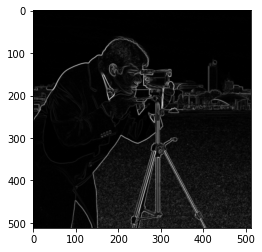

In [13]:
import cv2

ddepth = cv2.CV_64F  # 64-bit float output
#Do filter in x and y directions
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
sobel = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely, 2.0), 1.0, 0.0))

plt.imshow(sobel, cmap='gray');

In [14]:
#https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/
import cv2
def colHistRGB(image):
    # grab the image channels, initialize the tuple of colors,
    # the figure and the flattened feature vector
    chans = cv2.split(image)
    #is this right? Opencv seems to mess with RGB/BGR and I have no idea what colour is what...
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []

    #What do the bins represent? Value of colour channel?
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])   

Consider the following image:

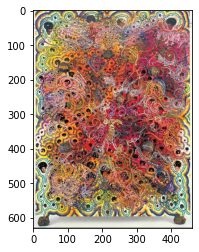

In [15]:
##Image from https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.6
orange_image_file = 'plate10.jpg'

orange_image = imread(orange_image_file)

plt.imshow(orange_image);

We can look at a colour histogram:

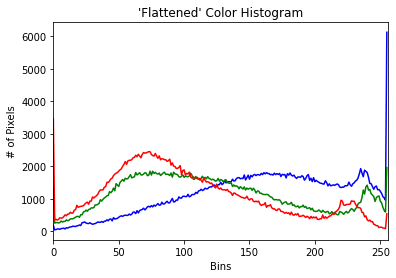

In [17]:
colHistRGB(orange_image)

One possible problem with the chart is that we don't know whether the separate high RGB channel values are at the same pixel (eg a white pixel) or spread across pixels.

Mayb a gray level brightness would identify high average RGB values as "bright" pixels?

(0.0, 256.0)

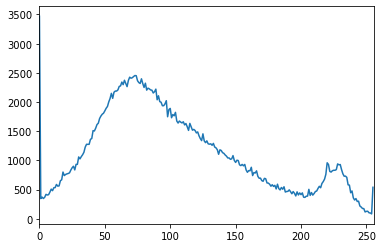

In [18]:
from skimage.io import imsave

imsave('testout.png', orange_image)
#COLOR_BGR2GRAY COLOR_RGBA2BGRA
img = cv2.imread('testout.png',cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)
plt.xlim([0, 256])   

How about a blue themed image - can we learn anything from the RGB plot about that?

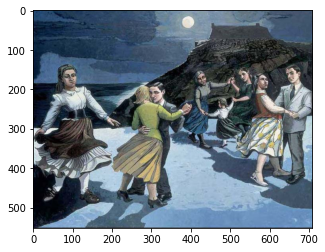

In [20]:
#Image from https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.6
blue_image_file = 'plate14.jpg'

blue_image = imread(blue_image_file)

plt.imshow(blue_image);

Here's the colour histogram:

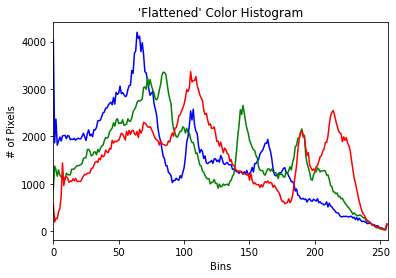

In [24]:
colHistRGB(blue_image) 

And the greyscale brightness:

(0.0, 256.0)

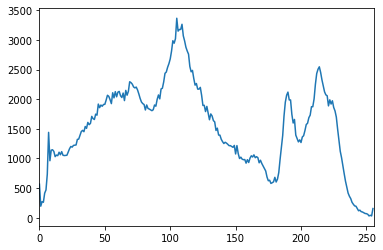

In [22]:
imsave('testout2.png', blue_image)

img = cv2.imread('testout2.png',cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img],[0], None, [256],[0,256])
plt.plot(hist)
plt.xlim([0, 256])  